In [94]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spreg import OLS
from libpysal.weights import Kernel
from esda.moran import Moran
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

In [2]:
# Read in all the data

AQMS_df=pd.read_csv('data/hourly.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')
loc_gdf=gpd.read_file('data/AQMS_loc.shp')
cond=pd.read_csv('data/cond_hourly.csv')

In [3]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)
loc_gdf.head()

,sitename,geometry,buffer_1km
siteid,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18..."


In [4]:
# Get all green spaces
Gsp=Gsp_gdf['geometry'].unary_union

# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [5]:
# Set buffer zones for every road (50m)
Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)
# Get all road buffer zones
Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [6]:
# Get all near-road green spaces
nRd_Gsp=Gsp.intersection(Rd_buffer)

In [7]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [8]:
# get all roads, green spaces and near-road green spaces in buffer zones around every sites
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp))

21 21 21


In [9]:
# append them into the dataframe
loc_gdf['Road']=Rd_shp
loc_gdf['GreenSpace']=Gsp_shp
loc_gdf['NR_GreenSpace']=nRd_Gsp_shp

# and set their data types to geometry
loc_gdf=loc_gdf.set_geometry('Road').set_geometry('GreenSpace').set_geometry('NR_GreenSpace')

In [10]:
# london boundary read in
london=gpd.read_file('data/london_boundary.shp')

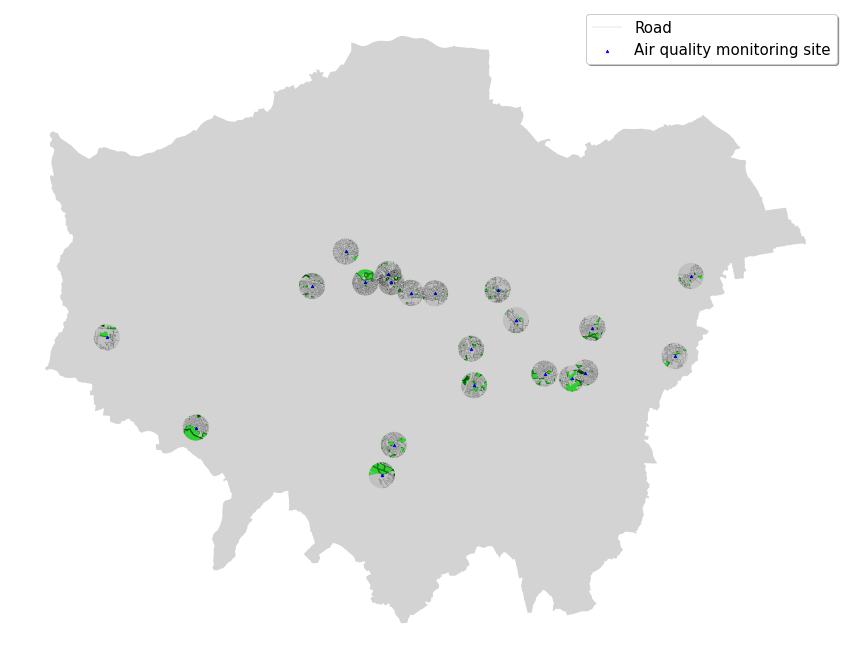

In [11]:
# visualise all the sites on the map
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [12]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [13]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis
siteid,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",1111.316933


In [14]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                    
       count       mean        std  min  25%   50%     75%   max
Site                                                            
BL0   8760.0  10.869803   9.945936  0.1  4.9   7.9  12.425  92.4
CD9   8760.0  13.753847  10.294305  0.1  7.4  11.1  16.300  83.9
GB0   8760.0  12.177603   8.968893  0.1  6.8   9.5  14.000  79.8
GR4   8760.0  11.002225   9.712762  0.1  5.4   8.3  12.300  97.6

In [15]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

Ttest_relResult(statistic=-64.50762336133032, pvalue=0.0)

In [16]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Ttest_relResult(statistic=-23.998842951363066, pvalue=2.5707190294625883e-123)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [17]:
# get the area of each buffer zone
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [18]:
loc_gdf['rd_len']=loc_gdf['Road'].length

In [19]:
# get percentages of green space and near-road green space areas 
loc_gdf['pct_Gsp_area']=loc_gdf['GreenSpace'].area/loc_gdf['buffer_area'] # percentage of gsp area
loc_gdf['pct_nR_Gsp_area']=loc_gdf['NR_GreenSpace'].area/loc_gdf['buffer_area'] # percentage of near road gsp area

In [20]:
loc_gdf['nR_Gsp_edge']=loc_gdf['NR_GreenSpace'].length

In [21]:
loc_gdf['nR_Gsp_per_rd_len']=loc_gdf['NR_GreenSpace'].area/loc_gdf['rd_len']

In [22]:
# merge PM reading and site geogemetry data
df=pd.merge(AQMS_df,loc_gdf,left_on='Site',right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Site               183960 non-null  object  
 1   Value              183960 non-null  float64 
 2   DateTime           183960 non-null  object  
 3   sitename           183960 non-null  object  
 4   geometry           183960 non-null  geometry
 5   buffer_1km         183960 non-null  geometry
 6   Road               183960 non-null  geometry
 7   GreenSpace         183960 non-null  geometry
 8   NR_GreenSpace      183960 non-null  geometry
 9   min_dis            183960 non-null  float64 
 10  buffer_area        183960 non-null  float64 
 11  rd_len             183960 non-null  float64 
 12  pct_Gsp_area       183960 non-null  float64 
 13  pct_nR_Gsp_area    183960 non-null  float64 
 14  nR_Gsp_edge        183960 non-null  float64 
 15  nR_Gsp_per_rd_len  183960 non-null

In [23]:
# drop irrelevant columns
df.drop(['sitename','buffer_1km','Road','GreenSpace','NR_GreenSpace','min_dis','buffer_area'],
        axis=1,inplace=True)

In [ ]:
df['Site'].unique().shape

In [ ]:
# prepare variables for the OLS model
Y=df['Value'].values
X=np.tile(cond[['bp_mean','tmp_mean','rh_mean']].values,(21,1))
print(X.shape,Y.shape)

In [ ]:
# fit a OLS model
m_multi=sm.OLS(Y,X)
m_multi_fit=m_multi.fit()
m_multi_fit.summary()

In [24]:
# kernel weight matrix for the sites
weight=Kernel.from_dataframe(loc_gdf,geom_col='geometry',function='gaussian')

In [25]:
# covert the DateTime column to numpy.datetime variable
df['DateTime']=pd.to_datetime(df['DateTime'])

In [26]:
# moran's Is for PM readings on different days
moran=[]
for date in df['DateTime'].unique():
    mi=Moran(df[df['DateTime']==date].Value.values,weight)
    moran.append(mi.I)
len(moran)

8760

<AxesSubplot:>

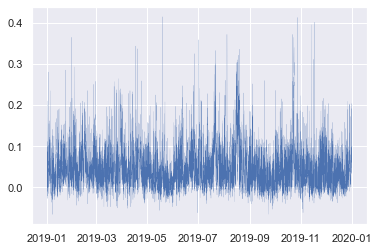

In [27]:
# change of moran's I during the year of 2019
sns.set_theme(style='darkgrid')
sns.lineplot(x=df['DateTime'].unique(),y=moran,linewidth=0.13)

In [28]:
# global moran's I for pct of gsp
moran_gsp=Moran(loc_gdf['pct_Gsp_area'].values,weight)
round(moran_gsp.I,5)

0.15159

In [29]:
# global moran's I for pct of near-road gsp
moran_nR=Moran(loc_gdf['pct_nR_Gsp_area'].values,weight)
round(moran_nR.I,5)

0.08686

In [31]:
moran_nR_per_Rd=Moran(loc_gdf['nR_Gsp_per_rd_len'].values,weight)
round(moran_nR_per_Rd.I,5)

0.131

In [32]:
# merge with conditional variables
cond['DateTime']=pd.to_datetime(cond['DateTime'])
df=df.merge(cond,on='DateTime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Site               183960 non-null  object        
 1   Value              183960 non-null  float64       
 2   DateTime           183960 non-null  datetime64[ns]
 3   geometry           183960 non-null  geometry      
 4   rd_len             183960 non-null  float64       
 5   pct_Gsp_area       183960 non-null  float64       
 6   pct_nR_Gsp_area    183960 non-null  float64       
 7   nR_Gsp_edge        183960 non-null  float64       
 8   nR_Gsp_per_rd_len  183960 non-null  float64       
 9   bp_mean            183960 non-null  float64       
 10  tmp_mean           183960 non-null  float64       
 11  rh_mean            183960 non-null  float64       
dtypes: datetime64[ns](1), float64(9), geometry(1), object(1)
memory usage: 18.2+ MB


array([[<AxesSubplot:title={'center':'Value'}>,
        <AxesSubplot:title={'center':'DateTime'}>,
        <AxesSubplot:title={'center':'rd_len'}>],
       [<AxesSubplot:title={'center':'pct_Gsp_area'}>,
        <AxesSubplot:title={'center':'pct_nR_Gsp_area'}>,
        <AxesSubplot:title={'center':'nR_Gsp_edge'}>],
       [<AxesSubplot:title={'center':'nR_Gsp_per_rd_len'}>,
        <AxesSubplot:title={'center':'bp_mean'}>,
        <AxesSubplot:title={'center':'tmp_mean'}>],
       [<AxesSubplot:title={'center':'rh_mean'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

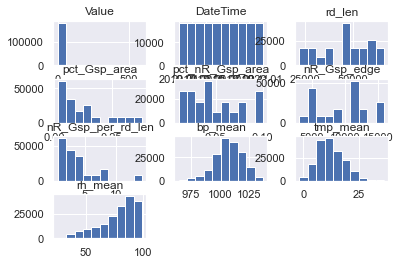

In [33]:
df.hist()

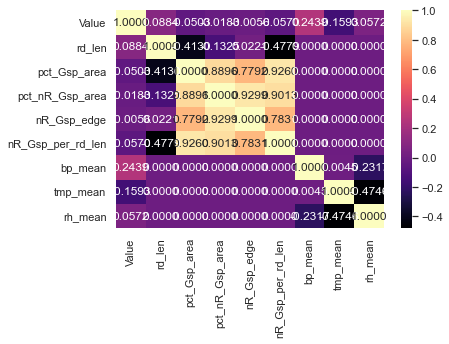

In [35]:
sns.heatmap(df.corr(method='spearman').round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [38]:
df['week']=df['DateTime'].dt.isocalendar().week

<AxesSubplot:xlabel='hour'>

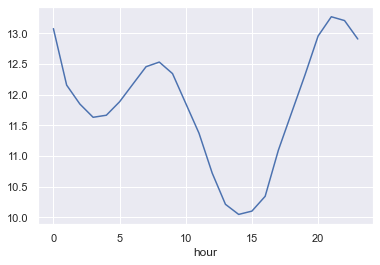

In [39]:
df['hour']=df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

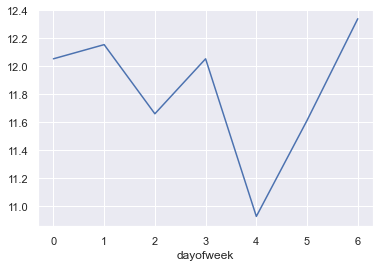

In [40]:
df['dayofweek']=df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

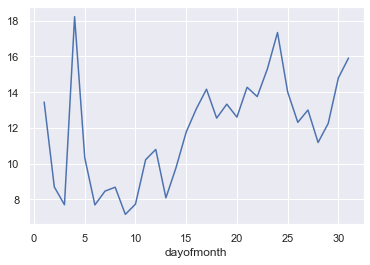

In [41]:
df['dayofmonth']=df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [42]:
hmean_site_df=df.groupby(['hour','Site']).mean()
hmean_site_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Value              504 non-null    float64
 1   rd_len             504 non-null    float64
 2   pct_Gsp_area       504 non-null    float64
 3   pct_nR_Gsp_area    504 non-null    float64
 4   nR_Gsp_edge        504 non-null    float64
 5   nR_Gsp_per_rd_len  504 non-null    float64
 6   bp_mean            504 non-null    float64
 7   tmp_mean           504 non-null    float64
 8   rh_mean            504 non-null    float64
 9   month              504 non-null    float64
 10  week               504 non-null    Float64
 11  dayofweek          504 non-null    float64
 12  dayofmonth         504 non-null    float64
dtypes: Float64(1), float64(12)
memory usage: 53.1+ KB


In [43]:
hmean_site_df.head()

Value        rd_len  pct_Gsp_area  pct_nR_Gsp_area  \
hour Site                                                           
0    BL0   11.430771  66247.190928      0.052078         0.042567   
     BX9   12.952238  36565.805888      0.062358         0.022665   
     CD1   11.153831  51527.369854      0.035043         0.012352   
     CD9   13.236543  60641.160028      0.052833         0.042514   
     CR8   12.142372  47234.530733      0.127605         0.038658   

            nR_Gsp_edge  nR_Gsp_per_rd_len      bp_mean   tmp_mean    rh_mean  \
hour Site                                                                       
0    BL0    9135.275555           2.015396  1007.938404  10.047669  87.513372   
     BX9    5069.994208           1.944190  1007.938404  10.047669  87.513372   
     CD1    4628.521968           0.751874  1007.938404  10.047669  87.513372   
     CD9   10863.710530           2.198958  1007.938404  10.047669  87.513372   
     CR8   10850.397208           2.567005  1007.938404  10.047669  87.513372   

              month       week  dayofweek  dayofmonth  
hour Site                                              
0    BL0   6.526027  26.430137   2.994521   15.720548  
     BX9   6.526027  26.430137   2.994521   15.720548  
     CD1   6.526027  26.430137   2.994521   15.720548  
     CD9   6.526027  26.430137   2.994521   15.720548  
     CR8   6.526027  26.430137   2.994521   15.720548

In [44]:
names=['rd_len','pct_Gsp_area','pct_nR_Gsp_area','nR_Gsp_edge','nR_Gsp_per_rd_len']

In [45]:
hmean_corr=[]
hmean_reg_score=[]
reg=LinearRegression()

for index in range(24):
    hmean_corr.append(hmean_site_df.loc[(index,)].corr(method='spearman').loc[names,'Value'])
    x=hmean_site_df.loc[(index,),names].values
    y=hmean_site_df.loc[(index,),'Value'].values
    reg.fit(x,y)
    hmean_reg_score.append(reg.score(x,y))
hmean_corr=np.asarray(hmean_corr)
print(hmean_corr.shape,len(hmean_reg_score))

(24, 5) 24


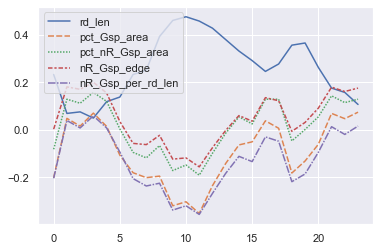

In [46]:
# this is the one uses spearman
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=names,loc='upper left')
plt.show()

In [ ]:
# this is the one uses pearson
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=names,loc='upper left')
plt.show()

<AxesSubplot:>

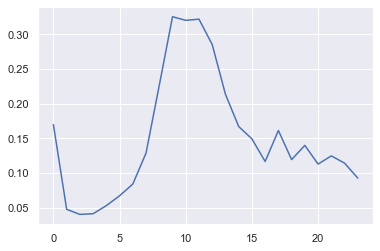

In [47]:
sns.lineplot(x=range(24),y=hmean_reg_score)

In [48]:
h_corr=[]
h_reg_score=[]
for h in range(24):
    h_corr.append(df[df['hour']==h].corr(method='spearman').loc[names,'Value'])
    x=df[df['hour']==h].loc[:,names].values
    y=df[df['hour']==h].loc[:,'Value'].values
    reg.fit(x,y)
    h_reg_score.append(reg.score(x,y))
h_corr=np.asarray(h_corr)
print(h_corr.shape,len(h_reg_score))

(24, 5) 24


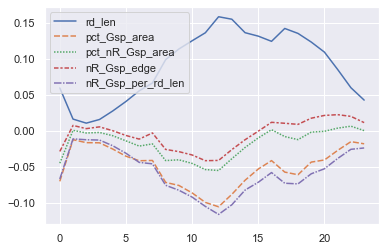

In [49]:
# this is the one uses spearman
sns.lineplot(data=h_corr,legend=False)
plt.legend(labels=names,loc='upper left')
plt.show()

In [ ]:
# this is the one uses pearson
sns.lineplot(data=h_corr,legend=False)
plt.legend(labels=names,loc='upper left')
plt.show()

<AxesSubplot:>

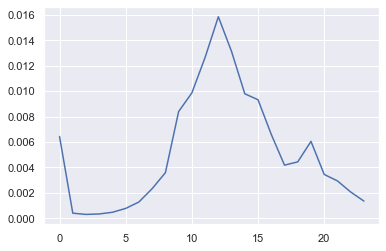

In [50]:
sns.lineplot(x=range(24),y=h_reg_score)

In [54]:
var_names=['rd_len','pct_Gsp_area','pct_nR_Gsp_area','nR_Gsp_edge','nR_Gsp_per_rd_len',
           'bp_mean','tmp_mean','rh_mean']

In [58]:
hmean_site_df.drop(['month','week','dayofweek','dayofmonth'],axis=1,inplace=True)

In [59]:
hmean_site_df.head()

Value        rd_len  pct_Gsp_area  pct_nR_Gsp_area  \
hour Site                                                           
0    BL0   11.430771  66247.190928      0.052078         0.042567   
     BX9   12.952238  36565.805888      0.062358         0.022665   
     CD1   11.153831  51527.369854      0.035043         0.012352   
     CD9   13.236543  60641.160028      0.052833         0.042514   
     CR8   12.142372  47234.530733      0.127605         0.038658   

            nR_Gsp_edge  nR_Gsp_per_rd_len      bp_mean   tmp_mean    rh_mean  
hour Site                                                                      
0    BL0    9135.275555           2.015396  1007.938404  10.047669  87.513372  
     BX9    5069.994208           1.944190  1007.938404  10.047669  87.513372  
     CD1    4628.521968           0.751874  1007.938404  10.047669  87.513372  
     CD9   10863.710530           2.198958  1007.938404  10.047669  87.513372  
     CR8   10850.397208           2.567005  1007.938404  10.047669  87.513372

<AxesSubplot:xlabel='month'>

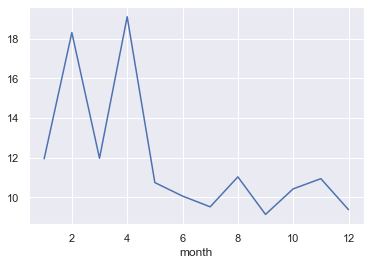

In [62]:
# set up a new column for month information
df['month']=df['DateTime'].dt.month

# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [103]:
mmean_corr=[]
mmean_reg_score=[]

for month in range(1,13):
    mmean_corr.append(df[df['month']==month].corr(method='spearman').loc[names,'Value'])
    x=df[df['month']==month].loc[:,names].values
    y=df[df['month']==month].loc[:,'Value'].values
    reg.fit(x,y)
    mmean_reg_score.append(reg.score(x,y))
mmean_corr=np.asarray(mmean_corr)
print(mmean_corr.shape,len(mmean_reg_score))

(12, 5) 12


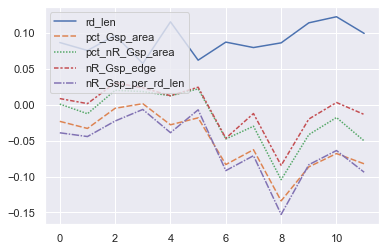

In [104]:
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=names,loc='upper left')
plt.show()

<AxesSubplot:>

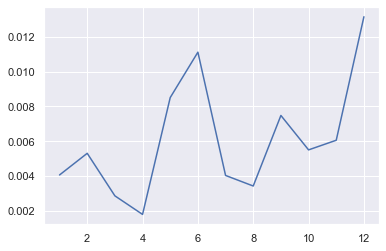

In [106]:
sns.lineplot(x=range(1,13),y=mmean_reg_score)

In [63]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].copy()
low=df[~df['month'].isin([1,2,3,4])].copy()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (60480, 17)
low: (123480, 17)


<AxesSubplot:>

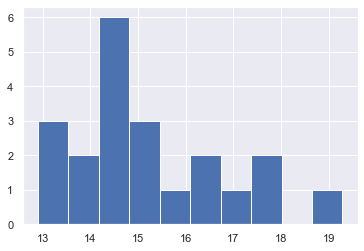

In [71]:
high.groupby('Site').mean()['Value'].hist()

array([[<AxesSubplot:title={'center':'rd_len'}>,
        <AxesSubplot:title={'center':'pct_Gsp_area'}>,
        <AxesSubplot:title={'center':'pct_nR_Gsp_area'}>],
       [<AxesSubplot:title={'center':'nR_Gsp_edge'}>,
        <AxesSubplot:title={'center':'nR_Gsp_per_rd_len'}>,
        <AxesSubplot:title={'center':'bp_mean'}>],
       [<AxesSubplot:title={'center':'tmp_mean'}>,
        <AxesSubplot:title={'center':'rh_mean'}>, <AxesSubplot:>]],
      dtype=object)

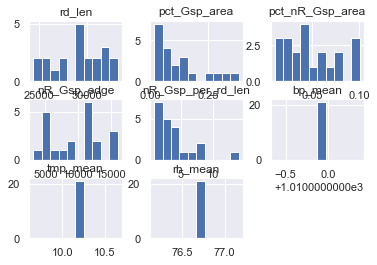

In [72]:
high.groupby('Site').mean()[var_names].hist()

In [101]:
test_y=(high.groupby('Site').mean()['Value'].values)
test_x=(high.groupby('Site').mean()[var_names].values)
pls=PLSRegression(n_components=1)
pls.fit(test_x,test_y)
cv_y=cross_val_predict(pls,test_x,test_y)
r2_score(test_y,cv_y)

-0.19096383096157665

In [92]:
pls.coef_

array([[ 4.96872773e-01],
       [ 3.70582651e-01],
       [-9.47751242e-02],
       [ 3.33849190e-01],
       [-4.11454349e-01],
       [-1.83923479e-27],
       [-2.87380436e-29],
       [ 2.29904349e-28]])

In [80]:
reg.fit(test_x,test_y)
reg.score(test_x,test_y)

0.15287313800857127